In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, MaxPool2D, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from random import choice, shuffle
from scipy import stats as st
from collections import deque

In [9]:
def gather_data(num_samples):
    global rock, paper, scissor, nothing
    
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    trigger = False
    counter=0
    box_size=234
    width=int(cap.get(3))
    
    while True:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        
        if not ret:
            break
        
        if counter==num_samples:
            trigger=not trigger
            counter=0
        cv2.rectangle(frame, (width-box_size, 0), (width, box_size), (0,250,150), 2)
        cv2.namedWindow("Collecting images", cv2.WINDOW_NORMAL)
        
        if trigger:
            roi = frame[5:box_size-5, width-box_size+5:width-5]
            eval(class_name).append([roi, class_name])
            counter+=1
            text = "Collected Samples of {}: {}".format(class_name, counter)
        else:
            text = "Press 'r' to collect samples for rock, 'p' for paper, 's' for sicssor and 'n' for nothing"
        
        cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,0,255), 1, cv2.LINE_AA)
        cv2.imshow("Collecting images", frame)
        k=cv2.waitKey(1)
        
        if k==ord('r'):
            trigger = not trigger
            class_name = 'rock'
            rock = []
        if k==ord('p'):
            trigger = not trigger
            class_name = 'paper'
            paper=[]
        if k==ord('s'):
            trigger = not trigger
            class_name = 'scissor'
            scissor = []
        if k==ord('n'):
            trigger = not trigger
            class_name = 'nothing'
            nothing=[]
        if k==ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

In [10]:
no_of_samples = 100
gather_data(no_of_samples)

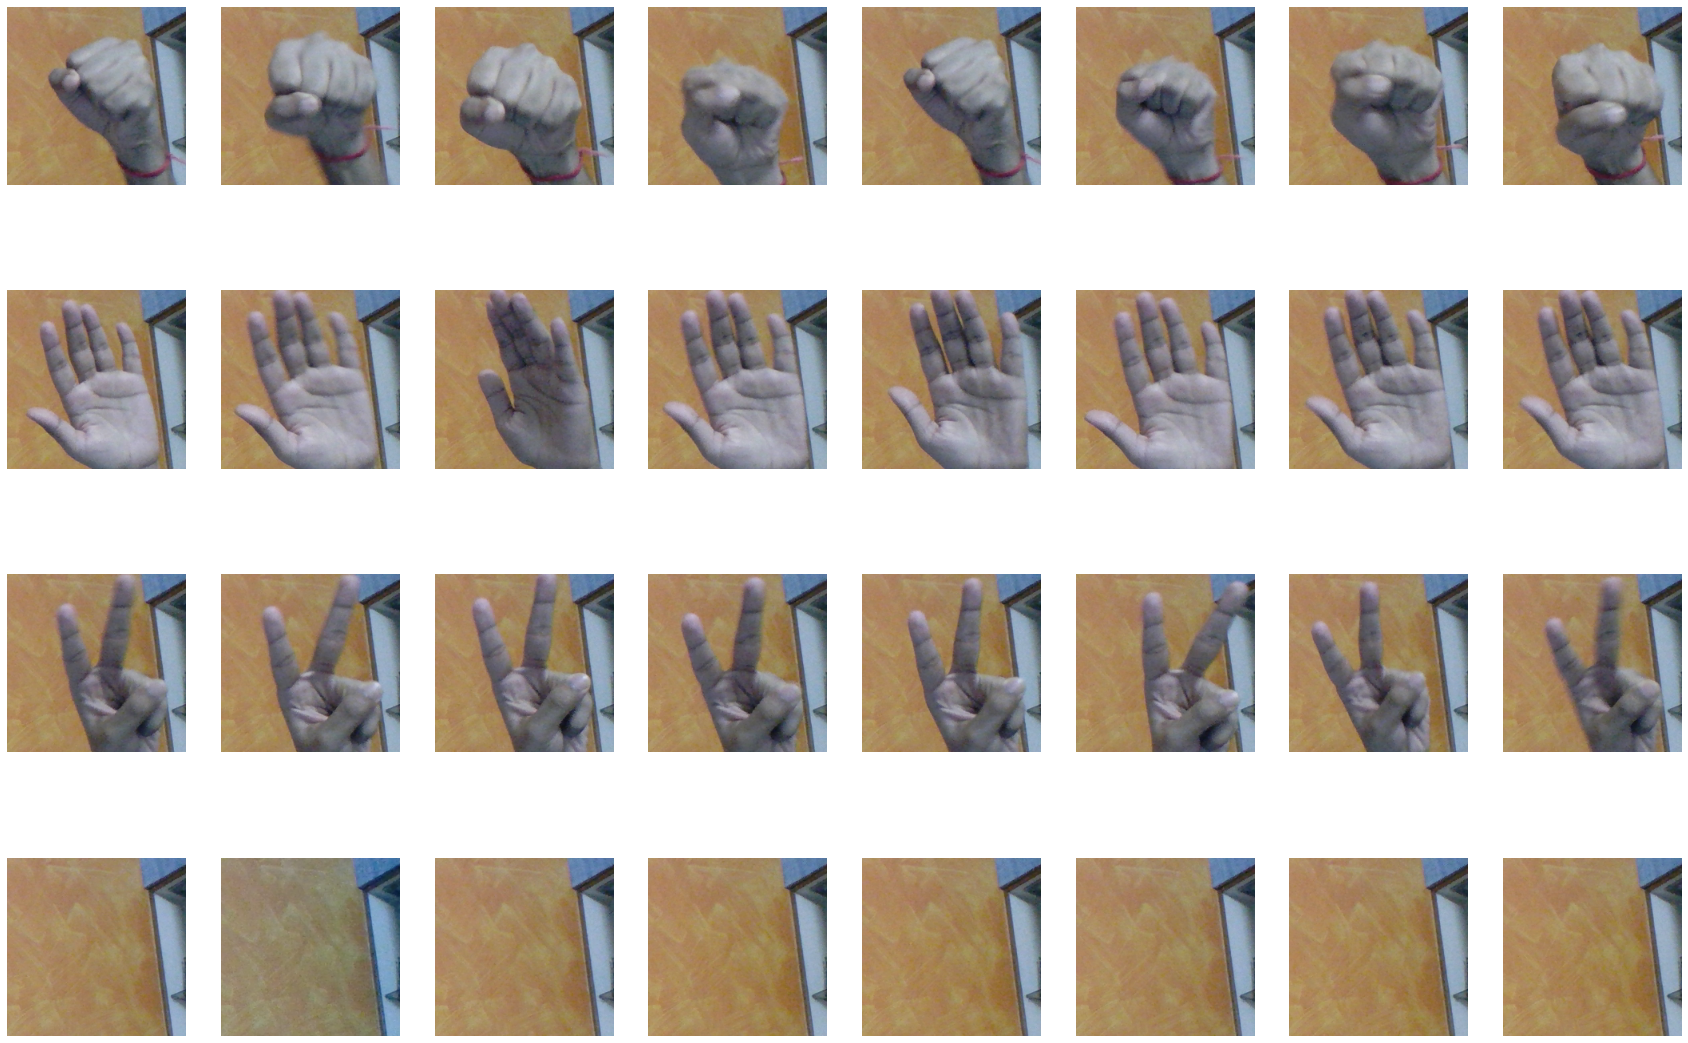

In [11]:
plt.figure(figsize=[30,20])
rows,col = 4,8
for class_index, each_list in enumerate([rock, paper, scissor, nothing]):
    r = np.random.randint(no_of_samples, size=8)
    for i, example_index in enumerate(r, 1):
        plt.subplot(rows, col, class_index*col+i)
        plt.imshow(each_list[example_index][0][:,:,::-1])
        plt.axis('off')

In [12]:
labels = [tup[1] for tup in rock] + [tup[1] for tup in paper] + [tup[1] for tup in scissor] + [tup[1] for tup in nothing]
images = [tup[0] for tup in rock] + [tup[0] for tup in paper] + [tup[0] for tup in scissor] + [tup[0] for tup in nothing]

images = np.array(images, dtype='float')/255.0

print('total images:{}, total labels:{}'.format(len(images), len(labels)))
encoder = LabelEncoder()

Int_labels = encoder.fit_transform(labels)

one_hot_labels = to_categorical(Int_labels, 4)

trainX, testX, trainY, testY = train_test_split(images, one_hot_labels, test_size=0.25, random_state=50)

images=[]

total images:400, total labels:400


In [13]:
print(len(rock), len(paper), len(scissor), len(nothing))

100 100 100 100


In [14]:
image_size = 224

N_mobile = tf.keras.applications.NASNetMobile(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
N_mobile.trainable=False
x  =N_mobile.output
x = GlobalAveragePooling2D()(x)
x = Dense(712, activation='relu')(x)
x=Dropout(0.40)(x)
preds = Dense(4, activation='sigmoid')(x)
model = Model(inputs=N_mobile.input, outputs=preds)
print("Number of Layers in Model: {}".format(len(model.layers[:])))

Number of Layers in Model: 773


In [15]:
augment = ImageDataGenerator(rotation_range=30,
                            zoom_range=0.25,
                            width_shift_range=0.10,
                            height_shift_range=0.10,
                            shear_range=0.10,
                            horizontal_flip=False,
                            fill_mode="nearest")

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
epochs=15
batchsize=20

history = model.fit(x=augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), steps_per_epoch=len(trainX)//batchsize, epochs=epochs)

Epoch 1/15
15/15 [==============================] - 42s 2s/step - loss: 1.1639 - accuracy: 0.5100 - val_loss: 0.7569 - val_accuracy: 0.9200
Epoch 2/15
15/15 [==============================] - 19s 1s/step - loss: 0.6310 - accuracy: 0.8467 - val_loss: 0.4030 - val_accuracy: 0.9900
Epoch 3/15
15/15 [==============================] - 19s 1s/step - loss: 0.3972 - accuracy: 0.9133 - val_loss: 0.2443 - val_accuracy: 0.9900
Epoch 4/15
15/15 [==============================] - 19s 1s/step - loss: 0.3199 - accuracy: 0.9300 - val_loss: 0.1606 - val_accuracy: 0.9900
Epoch 5/15
15/15 [==============================] - 19s 1s/step - loss: 0.2324 - accuracy: 0.9567 - val_loss: 0.1273 - val_accuracy: 0.9900
Epoch 6/15
15/15 [==============================] - 19s 1s/step - loss: 0.1699 - accuracy: 0.9733 - val_loss: 0.0882 - val_accuracy: 0.9900
Epoch 7/15
15/15 [==============================] - 19s 1s/step - loss: 0.1585 - accuracy: 0.9767 - val_loss: 0.0799 - val_accuracy: 0.9900
Epoch 8/15
15/15 [==

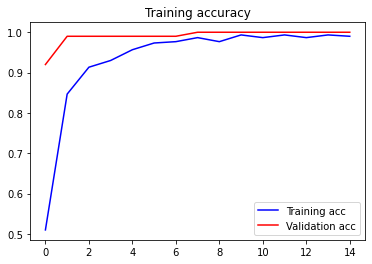

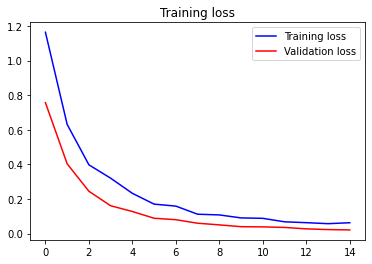

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label="Training loss")
plt.plot(epochs, val_loss, 'r', label="Validation loss")
plt.title('Training loss')
plt.legend()
plt.show()

In [19]:
model.save('rps4.h5', overwrite=True)

C:\Users\kunal\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [2]:
model = load_model('rps4.h5')

In [ ]:
label_names = ['nothing', 'paper', 'rock', 'scissor']

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
box_size=234
width=int(cap.get(3))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    
    cv2.rectangle(frame, (width-box_size,0), (width, box_size), (0,250,150),2)
    cv2.namedWindow("ROCK PAPER SCISSORS", cv2.WINDOW_NORMAL)
    roi = frame[5:box_size-5, width-box_size+5:width-5]
    
    roi = np.array([roi]).astype('float64')/255.0
    pred = model.predict(roi)
    
    target_index = np.argmax(pred[0])
    prob = np.max(pred[0])
    
    cv2.putText(frame, "prediction: {} {:.2f}%".format(label_names[target_index], prob*100), (10,40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0,0,255),2,cv2.LINE_AA)
    cv2.imshow("ROCK PAPER SCISSORS", frame)
    
    k = cv2.waitKey(1)
    if k==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [3]:
def findout_winner(user_move, Computer_move):
    if user_move == Computer_move:
        return 'Tie'
    elif user_move == 'rock' and Computer_move == 'scissor':
        return 'User'
    elif user_move == 'rock' and Computer_move == 'paper':
        return 'Computer'
    elif user_move == 'scissor' and Computer_move == 'rock':
        return 'Computer'
    elif user_move == 'scissor' and Computer_move == 'paper':
        return 'User'
    elif user_move == 'paper' and Computer_move == 'scissor':
        return 'Computer'
    elif user_move == 'paper' and Computer_move == 'rock':
        return 'User'

In [4]:
def show_winner(user_score, computer_score):
    if user_score>computer_score:
        
        img = cv2.imread('images/youwin.jpg')
    elif user_score<computer_score:
        img = cv2.imread('images/comwins.jpg')
    else:
        img = cv2.imread('images/draw.jpg')
    cv2.putText(img, "Press 'ENTER' to play again, else exit", (150,530), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 3, cv2.LINE_AA)
    cv2.imshow("ROCK PAPER SCISSORS", img)
    k = cv2.waitKey(0)
    if k==13:
        return True
    else:
        return False

In [5]:
def show_winner(user_score, computer_score):
    if user_score>computer_score:
        
        img = cv2.imread('images/youwin.jpg')
    elif user_score<computer_score:
        img = cv2.imread('images/comwins.jpg')
    else:
        img = cv2.imread('images/draw.jpg')
    cv2.putText(img, "Press 'ENTER' to play again, else exit", (150,530), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 3, cv2.LINE_AA)
    cv2.imshow("ROCK PAPER SCISSORS", img)
    k = cv2.waitKey(0)
    if k==13:
        return True
    else:
        return False

In [6]:
def display_computer_move(computer_move_name, frame):
    icon = cv2.imread('images/{}.png'.format(computer_move_name),1)
    icon = cv2.resize(icon, (224, 224))
    
    roi = frame[0:224, 0:224]
    mask = icon[:,:,-1]
    mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]
    icon_bgr = icon[:,:,:3]
    img1_bg = cv2.bitwise_and(roi, roi, mask = cv2.bitwise_not(mask))
    img2_fg = cv2.bitwise_and(icon_bgr, icon_bgr, mask=mask)
    combined = cv2.add(img1_bg, img2_fg)
    frame[:224, :224] = combined
    return frame

In [7]:
cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))
attempts=5
computer_move_name='nothing'
final_user_move='nothing'
label_names=['nothing', 'paper', 'rock', 'scissor']
computer_score, user_score = 0,0
rect_color = (255, 0, 0)
hand_inside = False
total_attempts = attempts
confidence_threshold = 0.70
smooth_factor=5
de = deque(['nothing']*5, maxlen=smooth_factor)

while True:
    ret, frame = cap.read()
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)
    cv2.namedWindow("ROCK PAPER SCISSORS", cv2.WINDOW_NORMAL)
    roi = frame[5:box_size-5, width-box_size+5:width-5]
    roi = np.array([roi]).astype('float64')/255.0
    pred = model.predict(roi)
    move_code = np.argmax(pred[0])
    user_move = label_names[move_code]
    prob = np.max(pred[0])
    
    if prob>confidence_threshold:
        de.appendleft(user_move)
        
        try:
            final_user_move = st.mode(de)[0][0]
        except StatisticsError:
            print('Stats error')
            continue
        
        if final_user_move!='nothing' and hand_inside==False:
            hand_inside = True
            
            computer_move_name = choice(['rock', 'paper', 'scissor'])
            winner = findout_winner(final_user_move, computer_move_name)
            
            display_computer_move(computer_move_name, frame)
            
            total_attempts-=1
            
            if winner=='Computer':
                computer_score+=1
                rect_color = (0, 0, 255)
            elif winner=='User':
                user_score+=1
                rect_color = (0, 250, 0)
            elif winner=='Tie':
                rect_color = (255, 250, 255)
            
            if total_attempts==0:
                play_again = show_winner(user_score, computer_score)
                
                if play_again:
                    user_score, computer_score, total_attempts = 0,0,attempts
                    
                else:
                    break
        elif final_user_move!='nothing' and hand_inside == True:
            display_computer_move(computer_move_name, frame)
            
        elif final_user_move == 'nothing':
            hand_inside=False
            rect_color = (255, 0, 0)
    
    cv2.putText(frame, "Your Move: " + final_user_move, (420,270), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, "Computer's Move: "+ computer_move_name, (2, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(frame, "Your Score: "+ str(user_score), (420, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(frame, "Computer's Score: "+ str(computer_score), (2, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(frame, "Attempts left: {}".format(total_attempts), (190, 400), cv2.FONT_HERSHEY_COMPLEX, 0.7, (100,2,255), 1, cv2.LINE_AA)
    
    cv2.rectangle(frame, (width-box_size, 0), (width, box_size), rect_color, 2)
    cv2.imshow("ROCK PAPER SCISSORS", frame)
    
    k = cv2.waitKey(10)
    if k==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()